### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
- [Usage](#Usage:)
- [Classification](#Classification)
- [Clustering](#Clustering)

### <font color='289C4E'>Usage:<font><a class='anchor' id='top'></a>
Create a venv
```bash
python -m venv venv
```
Install dependencies
```bash
pip install -r requirements.txt

sudo pacman -S graphviz # Arch Based
sudo apt install graphviz # Debian based
sudo dnf install graphviz # Fedora

```
Launch Jupyter notebook from the venv 
```bash
jupyter notebook
```

---

In [57]:
# import essential modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from graphviz import Digraph

# Clustering
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

### <font color='289C4E'>Classification<font><a class='anchor' id='top'></a>:

In [58]:
column_names = [
    'id', 'diagnosis',
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]
df = pd.read_csv("wdbc.data", header=None, names=column_names)
df['diagnosis'] = df['diagnosis'].map({'M': 0, 'B': 1}) 

# Separate features (X) and target (y)
X = df.drop(['id', 'diagnosis'], axis=1).values 
y = df['diagnosis'].values  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature    # Feature index to split on
        self.threshold = threshold  # Threshold value for splitting
        self.left = left          # Left subtree (less than or equal to threshold)
        self.right = right        # Right subtree (more than the threshold)
        self.value = value        # Class label (if leaf node)

class DecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.root = None

    def _gini(self, y):
        # Calculate Gini impurity for a set of labels
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def _best_split(self, X, y):
        # Find the best feature and threshold to split the data
        best_gini = float('inf')
        best_feature, best_threshold = None, None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                left_gini = self._gini(y[left_indices])
                right_gini = self._gini(y[~left_indices])
                weighted_gini = (left_gini * np.sum(left_indices) + right_gini * np.sum(~left_indices)) / len(y)

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth=0):
        # Recursively build the tree
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return Node(value=np.argmax(np.bincount(y)))

        feature, threshold = self._best_split(X, y)
        if feature is None:
            return Node(value=np.argmax(np.bincount(y)))

        left_indices = X[:, feature] <= threshold
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[~left_indices], y[~left_indices]

        left = self._build_tree(X_left, y_left, depth + 1)
        right = self._build_tree(X_right, y_right, depth + 1)

        return Node(feature, threshold, left, right)

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _predict_single(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)

    def predict(self, X):
        return np.array([self._predict_single(x, self.root) for x in X])

In [60]:
# Initialization and training of our custom tree
custom_tree = DecisionTree(max_depth=3)
custom_tree.fit(X_train, y_train)

# Predict and evaluate
y_pred_custom = custom_tree.predict(X_test)
print(f"Our custom Decision Tree accuracy:{accuracy_score(y_test, y_pred_custom):.2f}")

Our custom Decision Tree accuracy:0.94


In [61]:
def visualize_tree(node, feature_names, class_names, graph=None):
    if graph is None:
        graph = Digraph()
        graph.attr('node', shape='box', style='filled', color='lightgrey')
    
    if node.value is not None:
        class_label = class_names[node.value]
        graph.node(str(id(node)), label=class_label, fillcolor='lightblue')
    else:
        feature_name = feature_names[node.feature]
        label = f"{feature_name} ≤ {node.threshold:.2f}"
        graph.node(str(id(node)), label=label)
        
        visualize_tree(node.left, feature_names, class_names, graph)
        visualize_tree(node.right, feature_names, class_names, graph)
        
        graph.edge(str(id(node)), str(id(node.left)), label='Yes')
        graph.edge(str(id(node)), str(id(node.right)), label='No')
    
    return graph

feature_names = df.drop(['id', 'diagnosis'], axis=1).columns.tolist()
class_names = ['Malignant', 'Benign']

graph = visualize_tree(custom_tree.root, feature_names, class_names)
graph.render('decision_tree', view=True, format='png')
print("[Log]: Created decision_tree picture.")

[Log]: Created decision_tree picture.


### <font color='289C4E'>Clustering<font><a class='anchor' id='top'></a>

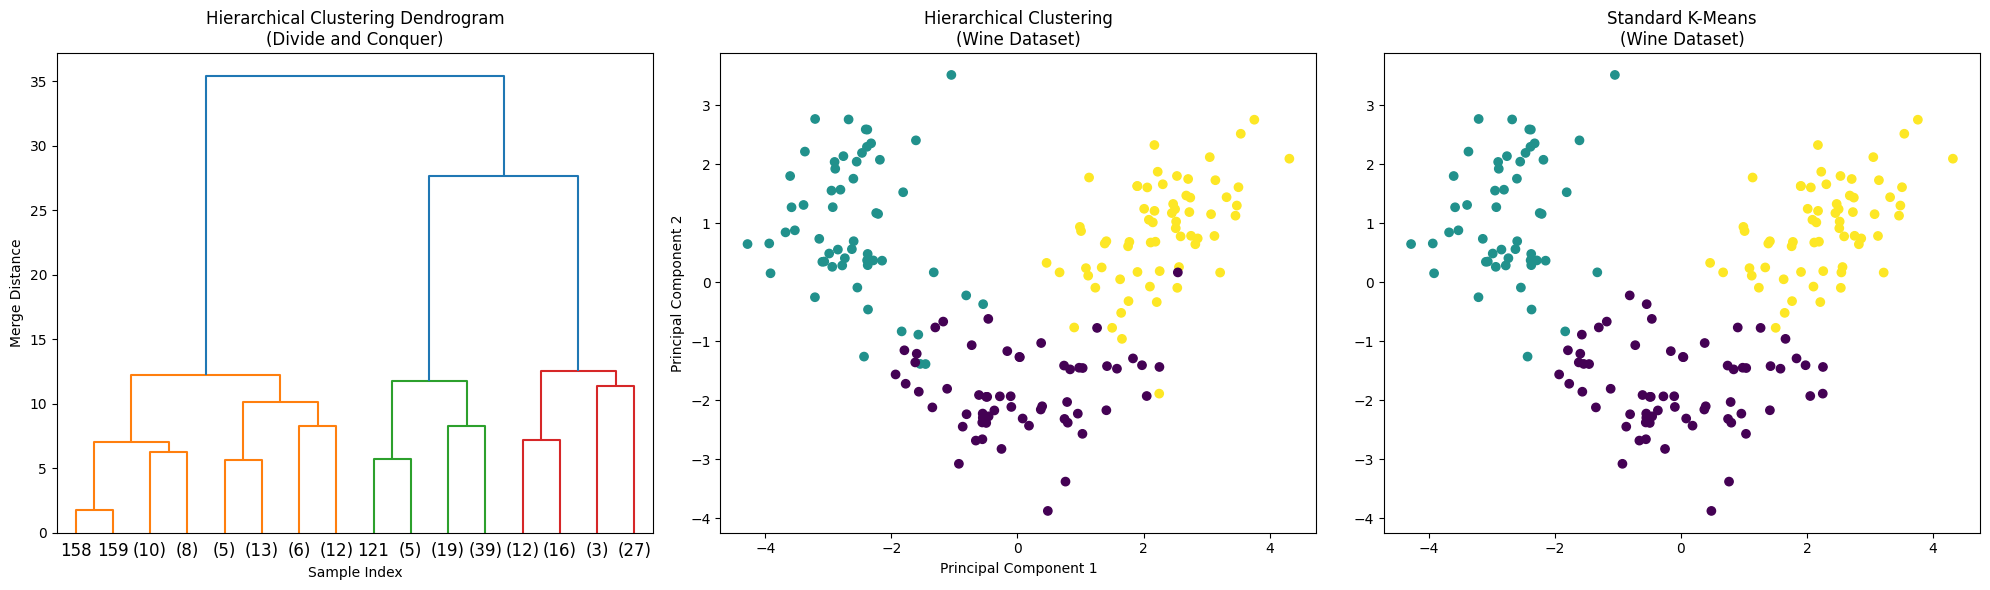

In [62]:
data = load_wine()
X = data.data
y = data.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Hierarchical Clustering (Divide and Conquer approach)
# ========================================================
Z = linkage(X_scaled, method='ward')

hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
hc_labels = hc.fit_predict(X_scaled)

# 2. Standard K-Means for comparison
# ==================================
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Visualization
# =============
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

dendrogram(Z, ax=ax1, truncate_mode='level', p=3)
ax1.set_title('Hierarchical Clustering Dendrogram\n(Divide and Conquer)')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Merge Distance')

ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=hc_labels, cmap='viridis')
ax2.set_title('Hierarchical Clustering\n(Wine Dataset)')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')

ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
ax3.set_title('Standard K-Means\n(Wine Dataset)')

plt.tight_layout()
plt.show()